In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import pickle

2025-10-07 12:59:58.864916: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-07 12:59:59.445196: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
%reload_ext autoreload
%autoreload 2

from spin_system import SpinSystem
from spin_system.interactions import gaussian_interaction
from spin_system.plots import plot_spin_evolution, plot_replica_overlap

In [3]:
lattice_dim = 2
lattice_length = 32
lattice_replicas = 32
initial_magnetization = .0

In [4]:
spin_glass = SpinSystem(
    lattice_dim = lattice_dim,
    lattice_length = lattice_length,
    lattice_replicas = lattice_replicas,
    interaction_matrix=gaussian_interaction(lattice_dim, lattice_length),
    model = 'spherical',
    initial_magnetization=initial_magnetization
)

I0000 00:00:1759852804.761330   50552 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


In [5]:
retry = 1
while retry < 3:
    try:
        lattice_dim = 2
        sweep_length = int(np.round(11000/retry))
        lattice_length = 32
        lattice_replicas = 32
        betas = tf.sort(
            tf.concat(
                [
                    tf.linspace(0.0001, 0.001, 20), 
                    tf.linspace(0.0011, 0.01, 20), 
                    tf.linspace(0.0105, 0.2, 5)
                ], 
                axis = 0
            )
        )

        interaction_matrix = gaussian_interaction(lattice_dim, lattice_length)
        spin_system = SpinSystem(
            lattice_dim=lattice_dim,
            lattice_length=lattice_length,
            lattice_replicas=lattice_replicas,
            interaction_matrix=interaction_matrix,
            model="spherical",
            initial_magnetization=0.0,
        )

        # Run the multi-temperature sweep
        results = spin_system.multi_temperature_sweep(
                betas=betas,
                num_disturb=tf.constant(1, dtype=tf.int32),
                theta_max=2*np.pi,
                sweep_length=sweep_length,
                restore_initial_state=True,
                track_spins=True,
                track_energy=True,
                track_magnetization=True,
                track_overlap=True
        )

        # Convert tensors to numpy arrays for saving
        results_to_save = {k: v.numpy() if isinstance(v, tf.Tensor) else v for k, v in results.items()}

        # Save the dict
        with open(f'../data/results_sherrington_kirkpatrick_2d_gaussian_{sweep_length}.pkl', 'wb') as f:
            pickle.dump(results_to_save, f)

        break

    except Exception as e:
        print(f"Error: {e}")
        retry += 1

In [ ]:
plot_spin_evolution(results["overlap_evolution"][:, -1, :, :], 51)

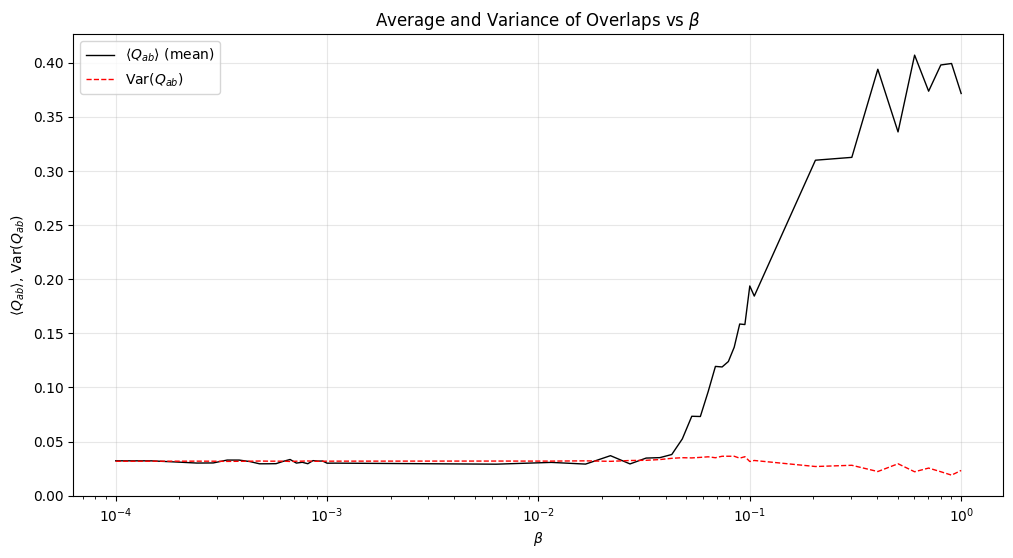

In [16]:
with open("../data/results_sherrington_kirkpatrick_2d_gaussian_30000.pkl", 'rb') as f:
    results = pickle.load(f)
    betas_sorted = results['betas']
    
mean_overlap = tf.reduce_mean(results["overlap_evolution"][:, -1, :, :], axis=[1, 2])
var_overlap = tf.math.reduce_variance(results["overlap_evolution"][:, -1, :, :], axis=[1, 2])


plt.figure(figsize=(12, 6))
# Plot mean
plt.plot(
    betas_sorted,
    mean_overlap,
    lw=1,
    color="black",
    label=r"$\langle Q_{ab}\rangle$ (mean)",
)

# Plot variance
plt.plot(
    betas_sorted,
    var_overlap,
    lw=1,
    ls="--",
    color="red",
    label=r"$\mathrm{Var}(Q_{ab})$",
)

plt.xscale("log")  # Logarithmic x-axis
plt.xlabel(r"$\beta$")
plt.ylabel(r"$\langle Q_{ab}\rangle$, $\mathrm{Var}(Q_{ab})$")
plt.title(r"Average and Variance of Overlaps vs $\beta$")
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()